# Book Recommendation system

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRanker

In [2]:
# !pip install kaggle

## Dataset

In [3]:
import kagglehub

# path = kagglehub.dataset_download("bahramjannesarr/goodreads-book-datasets-10m")
#
# print("Path to dataset files:", path)

In [4]:
DATA_PATH = kagglehub.dataset_download(
    "bahramjannesarr/goodreads-book-datasets-10m"
)

df = pd.read_csv(os.path.join(DATA_PATH, "book3000k-4000k.csv"))

In [5]:
df.head()

,Id,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,PagesNumber,Description
0,3000006,Simple Sermons on Great Christian Doctrines,W. Herschel Ford,0801091241,4.00,2001,10,1,Baker Books,5:0,4:1,3:0,2:0,1:0,total:1,0,NaN,80,A collection of simple sermons to help busy pa...
1,3000007,The Spinoza of Market Street,Isaac Bashevis Singer,0374502560,4.17,1979,2,1,"Farrar, Straus and Giroux",5:173,4:149,3:76,2:11,1:2,total:411,3,NaN,224,NaN
2,3000008,The Golem,Isaac Bashevis Singer,0374427461,3.77,1996,10,29,Farrar Straus Giroux,5:132,4:211,3:169,2:34,1:7,total:553,3,NaN,83,A clay giant miraculously brought to life by a...
3,3000009,Ujamaa Villages in Tanzania: Analysis of a Soc...,Michaela Von Freyhold,0853455120,0.00,1981,6,1,Monthly Review Press,5:0,4:0,3:0,2:0,1:0,total:0,0,NaN,201,NaN
4,3000011,Introducing Special Educational Needs: A Guide...,Philip Gardner,1853467332,3.33,2001,10,26,David Fulton Publishers,5:1,4:0,3:1,2:1,1:0,total:3,0,NaN,162,Pressure of time means that the complex topic ...


In [6]:
# files = os.listdir(path)
# print("Files in dataset:", files)

In [7]:
# df = pd.read_csv(os.path.join(path, 'book3000k-4000k.csv'))
# df.head()

In [8]:
# for f in os.listdir(path):
#     size_mb = os.path.getsize(os.path.join(path, f)) / (1024**2)
#     print(f, f"{size_mb:.2f} MB")


In [9]:
rating_df = pd.read_csv(os.path.join(DATA_PATH, 'user_rating_3000_to_4000.csv'))
rating_df.tail()

,ID,Name,Rating
46965,4278,A Short History of Philosophy,liked it
46966,4278,Profit Over People: Neoliberalism & Global Order,liked it
46967,4278,Controversies In American Public Policy,liked it
46968,4278,Brazil: Politics in a Patrimonial Society,liked it
46969,4278,Mexican Politics: The Dynamics of Change,liked it


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256595 entries, 0 to 256594
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               256595 non-null  int64  
 1   Name             256595 non-null  object 
 2   Authors          256595 non-null  object 
 3   ISBN             255860 non-null  object 
 4   Rating           256595 non-null  float64
 5   PublishYear      256595 non-null  int64  
 6   PublishMonth     256595 non-null  int64  
 7   PublishDay       256595 non-null  int64  
 8   Publisher        253600 non-null  object 
 9   RatingDist5      256595 non-null  object 
 10  RatingDist4      256595 non-null  object 
 11  RatingDist3      256595 non-null  object 
 12  RatingDist2      256595 non-null  object 
 13  RatingDist1      256595 non-null  object 
 14  RatingDistTotal  256595 non-null  object 
 15  CountsOfReview   256595 non-null  int64  
 16  Language         23037 non-null   obje

In [11]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46970 entries, 0 to 46969
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      46970 non-null  int64 
 1   Name    46970 non-null  object
 2   Rating  46970 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [12]:
print(f'dataframe shape: {df.shape}')
print(f'rating shape: {rating_df.shape}')

dataframe shape: (256595, 19)
rating shape: (46970, 3)


## Preprocessing

### Book dataframe

In [13]:
print("Duplicate values: ", df.duplicated().sum())

Duplicate values:  0


In [14]:
print("Nan values: ", df.isnull().sum().sum())

Nan values:  309549


In [15]:
for col in df:
    percentage = df[col].isna().sum() / df.shape[0] * 100
    if percentage > 0.5:
        print(f'{col}   {percentage:.2f} %')

Publisher   1.17 %
Language   91.02 %
Description   28.16 %


In [16]:
df.dropna(subset= ["Publisher"], inplace= True)
df.drop(columns=["Language"], inplace=True)

In [17]:
df.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'PublishYear',
       'PublishMonth', 'PublishDay', 'Publisher', 'RatingDist5', 'RatingDist4',
       'RatingDist3', 'RatingDist2', 'RatingDist1', 'RatingDistTotal',
       'CountsOfReview', 'PagesNumber', 'Description'],
      dtype='object')

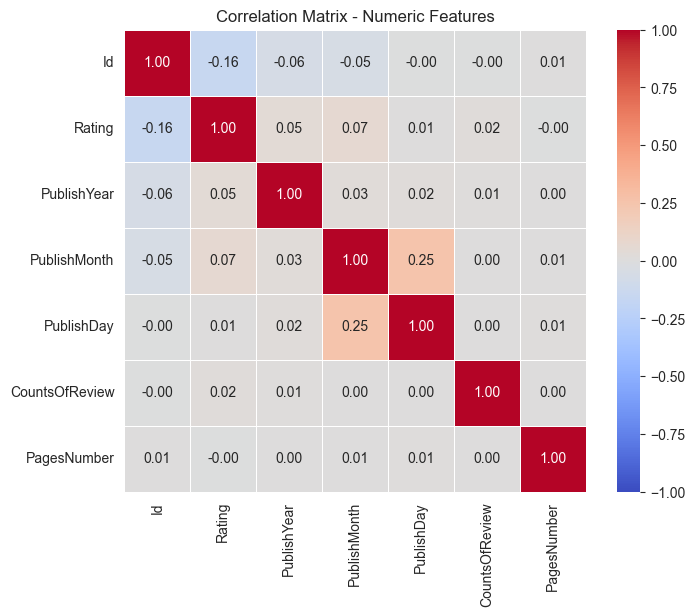

In [18]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5)

plt.title('Correlation Matrix - Numeric Features')
plt.show()

In [19]:
df['PublishYear'].unique()

array([ 2001,  1979,  1996,  1981,  2008,  2004,  1998,  2002,  2007,
        2020,  1983,  2006,  1980,  2000,  1992,  1999,  1995,  2009,
        2003,  1982,  1986,  1976,  1973,  1977,  1994,  1993,  1989,
        2005,  1987,  1985,  1978,  1997,  1990,  2010,  1900,  1988,
        1974,  1984,  1991,  1954,  2014,  1975,  2015,  1920,  2013,
        1941,  1970,  2012,  3006,  1924,  2011,  2019,  1963,  1971,
        1972,  1945,  1967,  1936,  1969,  1962,  1968,  2016,  1901,
        2018,  1965,  2017,  1951,  1966,  1958,  1952,  1960,  1927,
        1953,  2021,  1964,  1914,  1905,  1950,  1956,  1940,  1957,
        1959,  1934,  1955,  1961,  1925,  1937,  1948,  1911,  1944,
        1949,  1931, 20016,  1939,  1932,  1836,  1919,  1904,  1730,
        1946,  1938,  1902,  1947,  1923,  1926,  1942,  1929,  1930,
        1928,  1943,  1915,  1922,  1899,  1837,  1935,  2994,  1910,
        1865,  1897,  1933,  1921,  1825,  1896,  1884,  1918,  1893,
        1906,  1885,

In [20]:
df.shape

(253600, 18)

In [21]:
df = df[(df['PublishYear'] >= 1920) & (df['PublishYear'] <= 2025)]

In [22]:
df.shape

(253433, 18)

In [23]:
df['PublishYear'].unique()

array([2001, 1979, 1996, 1981, 2008, 2004, 1998, 2002, 2007, 2020, 1983,
       2006, 1980, 2000, 1992, 1999, 1995, 2009, 2003, 1982, 1986, 1976,
       1973, 1977, 1994, 1993, 1989, 2005, 1987, 1985, 1978, 1997, 1990,
       2010, 1988, 1974, 1984, 1991, 1954, 2014, 1975, 2015, 1920, 2013,
       1941, 1970, 2012, 1924, 2011, 2019, 1963, 1971, 1972, 1945, 1967,
       1936, 1969, 1962, 1968, 2016, 2018, 1965, 2017, 1951, 1966, 1958,
       1952, 1960, 1927, 1953, 2021, 1964, 1950, 1956, 1940, 1957, 1959,
       1934, 1955, 1961, 1925, 1937, 1948, 1944, 1949, 1931, 1939, 1932,
       1946, 1938, 1947, 1923, 1926, 1942, 1929, 1930, 1928, 1943, 1922,
       1935, 1933, 1921])

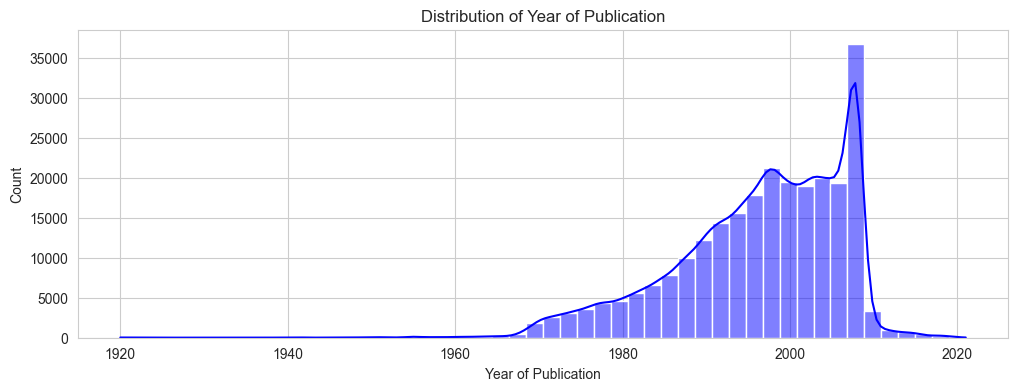

In [24]:
years = df['PublishYear']

plt.figure(figsize=(12, 4))
sns.histplot(years, bins=50, kde= True, color='blue')
plt.title("Distribution of Year of Publication")
plt.xlabel("Year of Publication")
plt.ylabel("Count")
plt.show()

In [25]:
df.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'PublishYear',
       'PublishMonth', 'PublishDay', 'Publisher', 'RatingDist5', 'RatingDist4',
       'RatingDist3', 'RatingDist2', 'RatingDist1', 'RatingDistTotal',
       'CountsOfReview', 'PagesNumber', 'Description'],
      dtype='object')

In [26]:
df['PublishMonth'].unique()

array([10,  2,  6,  9,  5, 12,  1,  4,  3,  8, 11,  7])

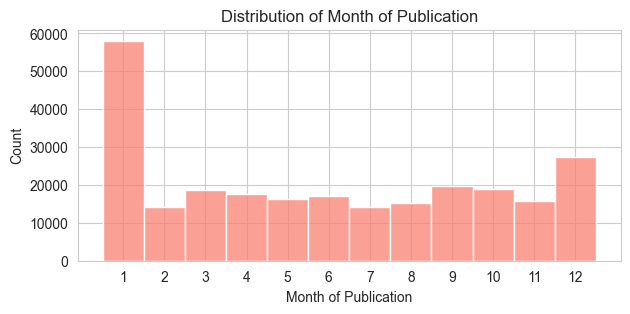

In [27]:
plt.figure(figsize=(7,3))
sns.histplot(df['PublishMonth'], bins= range(1,13), color="salmon", discrete=True)
plt.title("Distribution of Month of Publication")
plt.xticks(range(1,13))
plt.xlabel("Month of Publication")
plt.ylabel("Count")
plt.show()

In [28]:
df['Rating'].nunique()

304

In [29]:
df['Rating'].unique()


array([4.  , 4.17, 3.77, 0.  , 3.33, 3.99, 3.  , 3.5 , 5.  , 3.41, 3.55,
       3.87, 3.58, 3.8 , 3.89, 3.73, 3.22, 3.86, 4.43, 4.09, 4.57, 1.  ,
       2.75, 4.29, 3.38, 3.74, 4.08, 3.67, 3.61, 3.13, 3.96, 3.75, 4.5 ,
       3.4 , 4.04, 4.75, 3.48, 3.6 , 3.35, 2.5 , 3.93, 3.44, 4.05, 2.9 ,
       4.1 , 3.21, 4.2 , 4.16, 3.62, 4.01, 3.47, 4.33, 3.94, 4.62, 4.68,
       4.4 , 2.89, 2.3 , 4.24, 3.88, 3.81, 3.68, 3.43, 4.36, 4.31, 4.19,
       4.22, 3.98, 3.09, 4.38, 3.2 , 3.52, 3.7 , 4.21, 4.67, 3.97, 3.54,
       3.76, 2.  , 3.34, 3.95, 2.7 , 3.9 , 4.07, 4.83, 3.69, 3.79, 3.57,
       3.49, 4.14, 4.44, 3.92, 4.23, 4.15, 3.91, 3.07, 3.1 , 3.27, 2.33,
       3.83, 4.25, 3.3 , 4.03, 3.14, 3.17, 2.85, 3.24, 3.82, 2.8 , 4.13,
       3.71, 4.39, 3.39, 3.59, 4.06, 4.78, 3.45, 4.12, 3.18, 3.65, 2.4 ,
       4.34, 4.18, 3.84, 4.46, 3.53, 4.11, 1.67, 3.32, 3.72, 2.67, 3.12,
       3.78, 3.51, 3.16, 3.36, 4.71, 3.64, 4.42, 3.29, 2.64, 4.49, 4.35,
       4.02, 3.05, 4.28, 3.31, 3.37, 4.26, 4.37, 4.

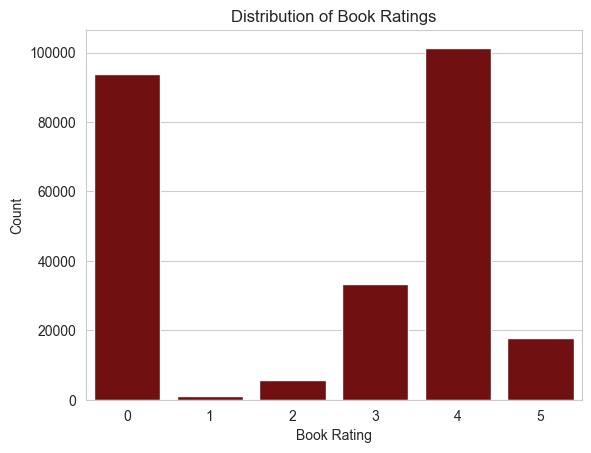

In [30]:
df["Rating_6"] = df["Rating"].round().clip(0, 5).astype(int)

sns.countplot(x="Rating_6", data=df, color="maroon")
plt.xticks([0, 1, 2, 3, 4, 5])
plt.title("Distribution of Book Ratings")
plt.xlabel("Book Rating")
plt.ylabel("Count")
plt.show()


In [31]:
df["RatingDistTotal"] = df["RatingDistTotal"].str.replace("total:","")

In [32]:
df.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'PublishYear',
       'PublishMonth', 'PublishDay', 'Publisher', 'RatingDist5', 'RatingDist4',
       'RatingDist3', 'RatingDist2', 'RatingDist1', 'RatingDistTotal',
       'CountsOfReview', 'PagesNumber', 'Description', 'Rating_6'],
      dtype='object')

In [33]:
df.drop(columns = [ 'RatingDist5', 'RatingDist4','RatingDist3', 'RatingDist2',
                    'RatingDist1', 'RatingDistTotal','CountsOfReview', 'PublishMonth'],
                    inplace = True, errors = "ignore")

In [34]:
df["Description"] = df["Description"].fillna("unknown")

In [35]:
df["Publisher"].value_counts()

Publisher
Springer                                                      7751
Routledge                                                     6237
Cambridge University Press                                    4441
Oxford University Press, USA                                  3934
Peter Lang Gmbh, Internationaler Verlag Der Wissenschaften    2535
                                                              ... 
Departamento de Ciencias de L                                    1
Gloucestershire County Council                                   1
Saint Francis Historical Society                                 1
Ridgetop Press                                                   1
Gesellschaft Fur Mittelrheinische Kirchengeschichte              1
Name: count, Length: 26388, dtype: int64

In [36]:
# df["Publisher"].unique().tolist()

In [37]:
df.shape

(253433, 11)

In [38]:
count = df["Publisher"].value_counts()

In [39]:
valid_publishers = count[count >= 2].index

df = df[df["Publisher"].isin(valid_publishers)]

In [40]:
df.shape

(238080, 11)

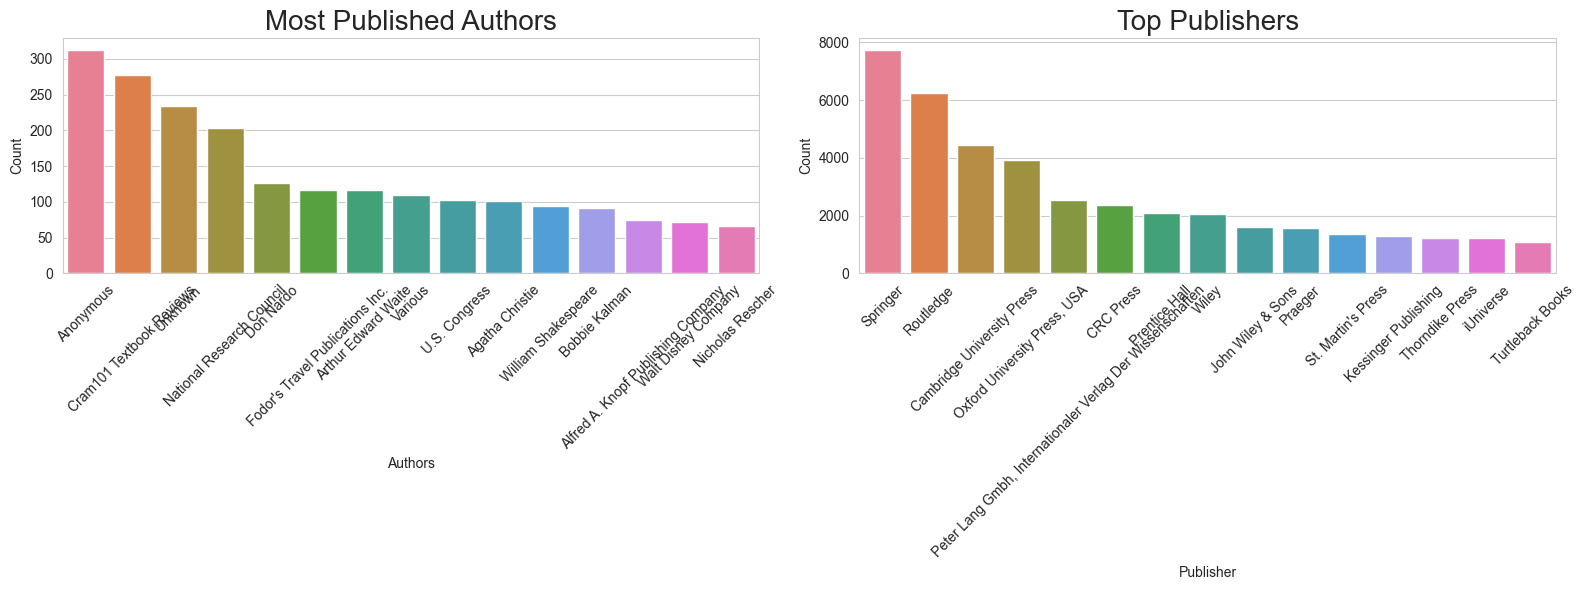

In [41]:
author_count = df['Authors'].value_counts().reset_index(name='Count').sort_values('Count', ascending=False).head(15)

publisher_count = df['Publisher'].value_counts().reset_index(name='Count').sort_values('Count', ascending=False).head(15)
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)

ax1 = sns.barplot(data=author_count, x='Authors', y='Count', hue="Authors" )
ax1.tick_params(axis="x", rotation=45)
ax1.set_title('Most Published Authors', size=20)

plt.subplot(1,2,2)
ax2 = sns.barplot(data=publisher_count, x='Publisher', y='Count', hue="Publisher")
ax2.tick_params(axis="x", rotation=45)
ax2.set_title('Top Publishers', size=20)

plt.tight_layout()

In [42]:
df.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'PublishYear', 'PublishDay',
       'Publisher', 'PagesNumber', 'Description', 'Rating_6'],
      dtype='object')

In [43]:
df["PublishDay"].unique()

array([ 1, 29, 26, 23, 16,  6, 30, 15, 17, 28,  4, 21,  9, 25, 31, 18,  3,
       14, 19, 12, 22, 24,  8, 10,  2, 13, 20, 11,  7,  5, 27])

In [44]:
# df["PublishDay"].value_counts()

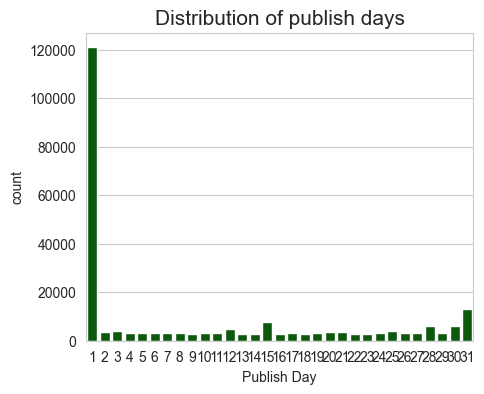

In [45]:
day_count = df["PublishDay"].value_counts()
plt.figure(figsize=(5,4))
sns.barplot(day_count, color= "darkgreen")
plt.title("Distribution of publish days", size=15)
plt.xlabel("Publish Day", size=10)
plt.show()

In [46]:
df.drop(columns=["PublishDay"], inplace=True)

In [47]:
df["PagesNumber"].unique()

array([  80,  224,   83, ..., 2312, 1381, 8608], shape=(1936,))

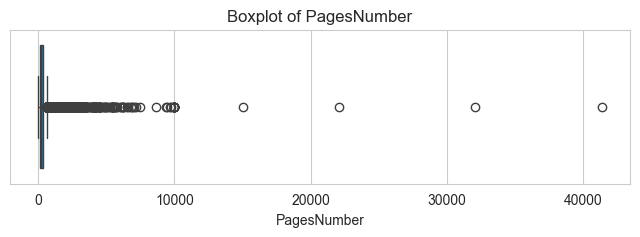

In [48]:
plt.figure(figsize=(8,2))
sns.boxplot(x=df["PagesNumber"])
plt.title("Boxplot of PagesNumber")
plt.show()


In [49]:
df = df[
    (df["PagesNumber"] >= 50) &
    (df["PagesNumber"] <= 12000)
]

In [50]:
df["Authors"].dtype

dtype('O')

In [51]:
df["Authors"].iloc[10:20]

10           Jesse G. Swan
11         Philip Grierson
12      Jennifer      Rose
13    Charity Scott-Stokes
14        Nuri N. Mohsenin
15          Harry L. Field
16          Peter Fraenkel
17      Keith S. Delaplane
18          Ling-Min Cheng
19       Amy T. McCandless
Name: Authors, dtype: object

In [52]:
df["Authors"] = df["Authors"].str.lower()
df['Authors'] = df['Authors'].str.replace(r'\s+', ' ', regex=True).str.strip()
chars_to_remove = r'[.,;:!?()\[\]{}"\'-]'
df['Authors'] = df['Authors'].str.replace(chars_to_remove, '', regex=True)
df['Authors'] = df['Authors'].str.replace(" ", "_")

In [53]:
df["Authors"].iloc[10:15]

10           jesse_g_swan
11        philip_grierson
12          jennifer_rose
13    charity_scottstokes
14        nuri_n_mohsenin
Name: Authors, dtype: object

In [54]:
df["Publisher"] = df["Publisher"].str.lower()
df['Publisher'] = df['Publisher'].str.replace(r'\s+', ' ', regex=True).str.strip()
chars_to_remove = r'[.,;:!?()\[\]{}"\'-]'
df['Publisher'] = df['Publisher'].str.replace(chars_to_remove, '', regex=True)
df['Publisher'] = df['Publisher'].str.replace(" ", "_")

In [55]:
df["Description"].iloc[10:15]

10                                              unknown
11    Coins are one of the most abundant sources for...
12                                              unknown
13    The book of hours is said to have been the mos...
14    This book discusses the methods for determinat...
Name: Description, dtype: object

In [56]:
df["Description"] = df["Description"].str.lower()
df['Description'] = df['Description'].str.replace(r'\s+', ' ', regex=True).str.strip()
chars_to_remove = r'[.,;:!?()\[\]{}"\'-<>]'
df['Publisher'] = df['Publisher'].str.replace(chars_to_remove, '', regex=True)

In [57]:
df.tail(3)

,Id,Name,Authors,ISBN,Rating,PublishYear,Publisher,PagesNumber,Description,Rating_6
256592,3724827,Rodale's Complete Home Products Manual: The Be...,rodale_press,0878577971,0.0,1989,rodale_press,354,unknown,0
256593,3724833,Doing Business in Arizona: A Legal Guide,snell_&_wilmer_associates,0816518890,0.0,1998,university_of_arizona_press,330,<b><i>doing business in arizona</i> brings tog...,0
256594,3724836,Mennonite Identity in Conflict,leo_driedger,0889468559,0.0,1988,edwin_mellen_press,237,mennonites still comprise one of the most mark...,0


In [58]:
for col in ["Authors", "Publisher"]:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [59]:
df.head()

,Id,Name,Authors,ISBN,Rating,PublishYear,Publisher,PagesNumber,Description,Rating_6
0,3000006,Simple Sermons on Great Christian Doctrines,146428,0801091241,4.00,2001,909,80,a collection of simple sermons to help busy pa...,4
1,3000007,The Spinoza of Market Street,60029,0374502560,4.17,1979,3341,224,unknown,4
2,3000008,The Golem,60029,0374427461,3.77,1996,3343,83,a clay giant miraculously brought to life by a...,4
3,3000009,Ujamaa Villages in Tanzania: Analysis of a Soc...,101736,0853455120,0.00,1981,6314,201,unknown,0
4,3000011,Introducing Special Educational Needs: A Guide...,114754,1853467332,3.33,2001,2525,162,pressure of time means that the complex topic ...,3


In [60]:
df['Name'] = df['Name'].str.lower().str.strip()

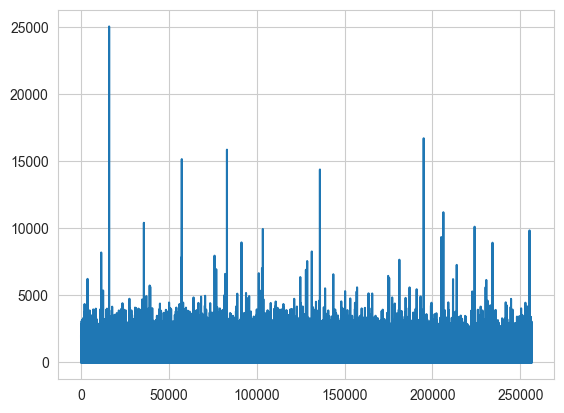

In [61]:
plt.plot(df["Description"].str.len())

In [62]:
no = (df["Description"] == "unknown").sum()
per = no / df.shape[0] * 100
print(per)

26.347758299072883


In [63]:
df["Description"] = df["Description"].replace("unknown", "")

In [64]:
tfidf = TfidfVectorizer(stop_words="english", max_features= 5000)
description_tfidf = tfidf.fit_transform(df["Description"])
description_df = pd.DataFrame(description_tfidf.toarray(),columns= tfidf.vocabulary_ , index= df.index)

In [65]:
description_df.head()

,collection,simple,sermons,help,busy,prepare,biblical,messages,important,christian,...,reliability,epistemology,je,welche,reformation,hazards,dickens,laser,algebraic,cram101
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
description_df['Name'] = df['Name']

In [67]:
description_df.head()

,collection,simple,sermons,help,busy,prepare,biblical,messages,important,christian,...,epistemology,je,welche,reformation,hazards,dickens,laser,algebraic,cram101,Name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,simple sermons on great christian doctrines
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,the spinoza of market street
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,the golem
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ujamaa villages in tanzania: analysis of a soc...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,introducing special educational needs: a guide...


In [68]:
df.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'PublishYear', 'Publisher',
       'PagesNumber', 'Description', 'Rating_6'],
      dtype='object')

In [69]:
df.drop(columns=['ISBN', 'Rating', 'PagesNumber','Rating_6'], inplace=True)

In [70]:
df.head()

,Id,Name,Authors,PublishYear,Publisher,Description
0,3000006,simple sermons on great christian doctrines,146428,2001,909,a collection of simple sermons to help busy pa...
1,3000007,the spinoza of market street,60029,1979,3341,
2,3000008,the golem,60029,1996,3343,a clay giant miraculously brought to life by a...
3,3000009,ujamaa villages in tanzania: analysis of a soc...,101736,1981,6314,
4,3000011,introducing special educational needs: a guide...,114754,2001,2525,pressure of time means that the complex topic ...


### Rating dataframe

In [71]:
print("Nan values: ", rating_df.isnull().sum().sum())

Nan values:  0


In [72]:
rating_df["Rating"].unique()

array(["This user doesn't have any rating", 'it was ok', 'liked it',
       'really liked it', 'it was amazing', 'did not like it'],
      dtype=object)

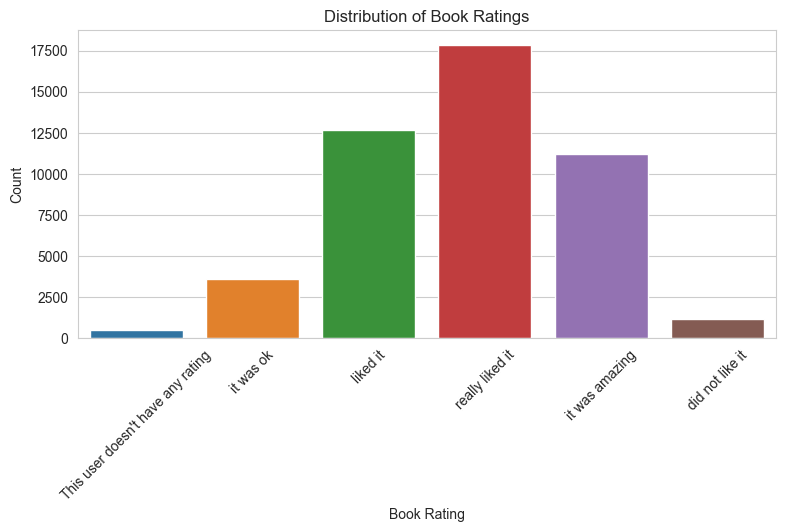

In [73]:
plt.figure(figsize=(9, 4))
sns.countplot(x='Rating', data= rating_df, hue= "Rating")
plt.title("Distribution of Book Ratings")
plt.xlabel("Book Rating")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

In [74]:
non_rate = (rating_df["Rating"] == "This user doesn't have any rating").sum()
per = non_rate / rating_df.shape[0] * 100
print(per)

1.0602512241856505


In [75]:
rating_df.columns

Index(['ID', 'Name', 'Rating'], dtype='object')

In [76]:
rating_df["Rating"] = rating_df["Rating"].replace("This user doesn't have any rating", pd.NA)

In [77]:
rating_df.dropna(inplace=True)

In [78]:
# le = LabelEncoder()
# le.fit(['it was ok', 'liked it', 'really liked it', 'it was amazing', 'did not like it'])
# le.transform(['it was ok', 'liked it', 'really liked it', 'it was amazing', 'did not like it'])

In [79]:
# ordinal
rating_map = {
    'did not like it': 1,
    'it was ok': 2,
    'liked it': 3,
    'really liked it': 4,
    'it was amazing': 5
}

rating_df['rating_numeric'] = rating_df['Rating'].map(rating_map)

In [80]:
rating_df['Name'] = rating_df['Name'].str.lower().str.strip()

In [81]:
rating_df.head()

,ID,Name,Rating,rating_numeric
498,3474,hooked: how to build habit-forming products,it was ok,2
499,3225,of mice and men,liked it,3
500,3259,of mice and men,it was ok,2
501,3380,of mice and men,really liked it,4
502,3420,of mice and men,really liked it,4


In [82]:
rating_df_copy = rating_df.copy()

In [83]:
rating_df_copy.drop(columns=["Rating"],inplace=True)

In [84]:
rating_df_copy.head(3)

,ID,Name,rating_numeric
498,3474,hooked: how to build habit-forming products,2
499,3225,of mice and men,3
500,3259,of mice and men,2


### Builld main dataframe

In [85]:
df.head()

,Id,Name,Authors,PublishYear,Publisher,Description
0,3000006,simple sermons on great christian doctrines,146428,2001,909,a collection of simple sermons to help busy pa...
1,3000007,the spinoza of market street,60029,1979,3341,
2,3000008,the golem,60029,1996,3343,a clay giant miraculously brought to life by a...
3,3000009,ujamaa villages in tanzania: analysis of a soc...,101736,1981,6314,
4,3000011,introducing special educational needs: a guide...,114754,2001,2525,pressure of time means that the complex topic ...


## Model Selection

In [123]:
# group =

In [125]:
# model = XGBRanker(
#     objective="rank:pairwise",
#     n_estimators= 200,
#     learning_rate= 0.1,
#     max_depth= 5,
#     subsample= 0.8,
#     colsample_bytree= 0.8,
# )
# model.fit(X, y, group= group)

,objective,'rank:pairwise'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [136]:
# use_books = [
#     "1984",
#     "empire",
#     "a writer's reference"
# ]
# user_index = final_df[final_df["Name"].isin(use_books)].index
# user_index

In [ ]:
# df["Score"] = df["rank"] + similarity_score *3

## Test & Evaluate